<a href="https://colab.research.google.com/github/Ammar-tech12/Analisis-Sentimen/blob/main/FineTuning_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers

In [ ]:
!pip install numpy==1.26.4
# Restart runtime after installing a new numpy version
import os
os.kill(os.getpid(), 9)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from transformers import AutoTokenizer, DistilBertTokenizer, \
    AutoModel, AutoModelForSequenceClassification, \
    Trainer, TrainingArguments

In [1]:
from datasets import list_datasets
from datasets import load_dataset

In [2]:
!pip install datasets==2.18.0 fsspec==2024.2.0

In [3]:
emotions = load_dataset("emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]

In [6]:
train_ds[67]

{'text': 'i have been on a roller coaster of emotions over these supposed feelings that something unpleasant was coming',
 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
labels = emotions["train"].features["label"].names

In [10]:
emotions["train"].features["label"].num_classes

6

In [11]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [12]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [14]:
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [15]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


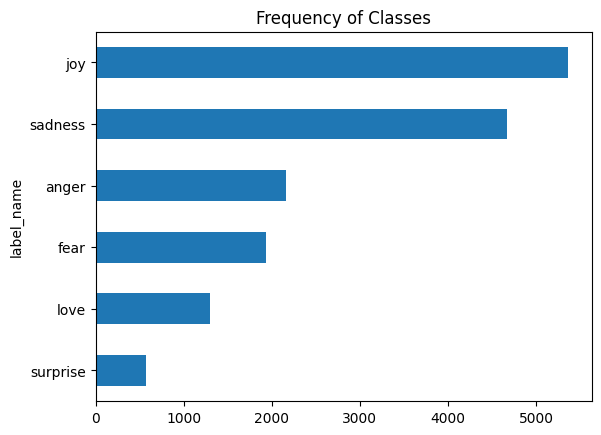

In [16]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

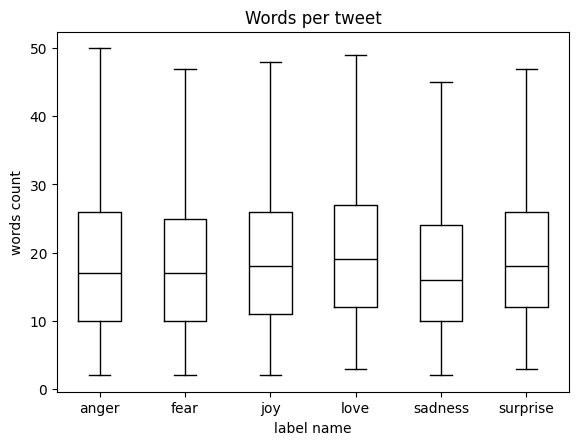

In [17]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("label name")
plt.ylabel("words count")
plt.show()

In [18]:
# remove pandas dataframe format
emotions.reset_format()

In [19]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [21]:
text = "Sentence as an example."

In [22]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 6251, 2004, 2019, 2742, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]', 'sentence', 'as', 'an', 'example', '.', '[SEP]']

In [24]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] sentence as an example. [SEP]'

In [25]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

In [26]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [28]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']

In [29]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [30]:
text

'Sentence as an example.'

In [31]:
inputs = tokenizer(text, return_tensors="pt")
inputs, inputs['input_ids'].size()

({'input_ids': tensor([[ 101, 6251, 2004, 2019, 2742, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])},
 torch.Size([1, 7]))

In [32]:
# encodings as a tensor
inputs['input_ids']

tensor([[ 101, 6251, 2004, 2019, 2742, 1012,  102]])

In [33]:
# derive last hidden state
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.3701, -0.2720, -0.2445,  ..., -0.0752,  0.0055,  0.3905],
         [ 0.0033, -0.0159, -0.2230,  ..., -0.0974,  0.2104, -0.3824],
         [-0.2426,  0.0827, -0.1300,  ..., -0.0083,  0.0249,  0.2278],
         ...,
         [-0.5364,  0.3529, -0.5220,  ..., -0.3421, -0.1590, -0.0726],
         [-0.6819, -0.7566, -0.4331,  ...,  0.3827,  0.2073, -0.1503],
         [ 0.9874,  0.0497, -0.4902,  ...,  0.2408, -0.7476, -0.2267]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [34]:
# 768-dimensionality vector is returned for each of 7 tokens
outputs.last_hidden_state.size()

torch.Size([1, 7, 768])

In [35]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [36]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [39]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [41]:
# takes time to run this cell!!
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
lr.score(X_valid, y_valid)

0.634

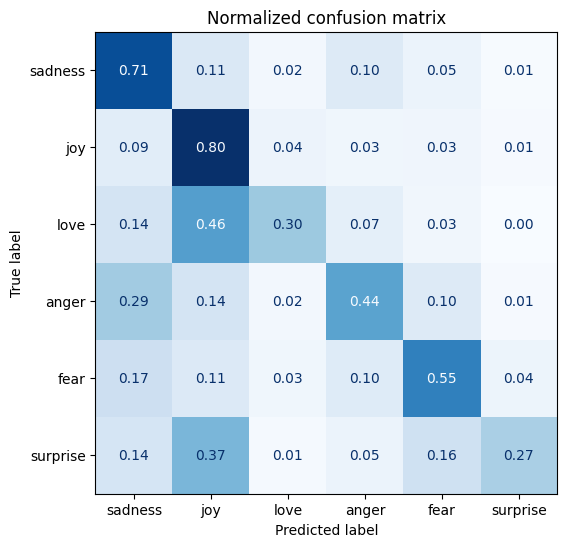

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [44]:
model_ckpt, labels

('distilbert-base-uncased',
 ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [46]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
num_labels

6

In [60]:
# define performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    label_prediction = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(label_prediction, preds, average="weighted")
    acc = accuracy_score(label_prediction, preds)
    return {"accuracy": acc, "f1": f1}

In [61]:
from huggingface_hub import notebook_login
notebook_login()

In [57]:
from transformers import TrainingArguments, Trainer

batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion-tweets"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch", # Changed from evaluation_strategy
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

/tmp/ipython-input-57-4115227610.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [62]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.171948,0.929000,0.929596
2,No log,0.152838,0.935500,0.935601


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=500, training_loss=0.1789408721923828, metrics={'train_runtime': 228.5785, 'train_samples_per_second': 139.996, 'train_steps_per_second': 2.187, 'total_flos': 1080514292544000.0, 'train_loss': 0.1789408721923828, 'epoch': 2.0})

In [63]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.1528376191854477,
 'test_accuracy': 0.9355,
 'test_f1': 0.9356007800383545,
 'test_runtime': 3.9778,
 'test_samples_per_second': 502.79,
 'test_steps_per_second': 8.045}

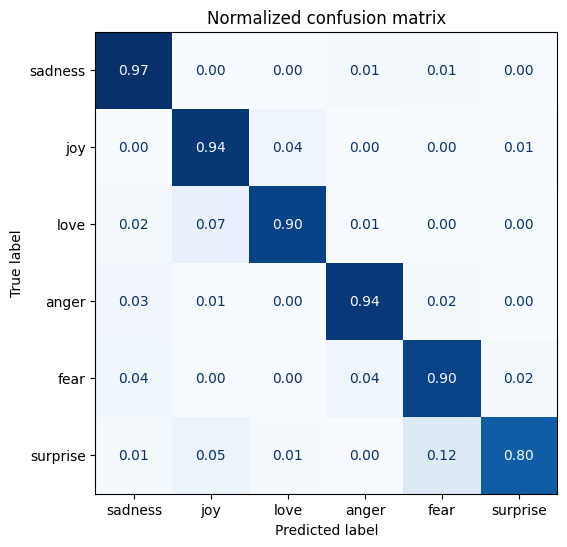

In [64]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)